In this notebook we will be looking at the fashion mnist data where the goal is to correctly classify images of clothes into one of several categories.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

X_train_full.shape

(60000, 28, 28)

The load_data function returns a training set and a test set. Looking at the training set, we see that it is made up of 60,000 images, each of size 28 x 28.

Let us split the training set into a train set and a validation set. We will also divide the values of the pixels by 255 as a form of standardization:

In [5]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

Let us now look at the category of the first record in the training set:

In [6]:
class_names[y_train[0]]

'Coat'

We see that it is a coat. Let us now display the image of this record:

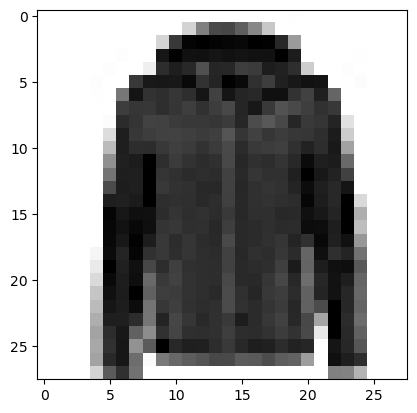

In [7]:
plt.imshow(X_train[0], cmap="binary")
plt.show()

We see that it is an image of a coat. You can display any of the images in the training set in order to have an idea what the images look like.

We will now train a fully connected model to see how it performs, and then we will train a convoluted network in order to be able to compare it with the fully connected model.

In [8]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4781 - accuracy: 0.8287 - val_loss: 0.3932 - val_accuracy: 0.8564
Epoch 2/20
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3618 - accuracy: 0.8654 - val_loss: 0.3697 - val_accuracy: 0.8640
Epoch 3/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3276 - accuracy: 0.8785 - val_loss: 0.3117 - val_accuracy: 0.8878
Epoch 4/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3010 - accuracy: 0.8874 - val_loss: 0.3080 - val_accuracy: 0.8872
Epoch 5/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2862 - accuracy: 0.8932 - val_loss: 0.3100 - val_accuracy: 0.8854
Epoch 6/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2729 - accuracy: 0.8979 - val_loss: 0.3054 - val_accuracy: 0.8950
Epoch 7/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2591 - accuracy: 0.9015 - val_loss: 0.3044 - val_accurac

We see that the accuracy on the validation set is around 89%, which is not bad for a model that was trained so fast. Let us evaluate the model using the test data set:

In [9]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 76.0306 - accuracy: 0.8633


[76.03063201904297, 0.8633000254631042]

The accuracy on the test data set is around 86%.